In [ ]:
import os
import zipfile
from PIL import Image
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from tensorflow.keras import Model

# Step 1: Loading Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/cats_and_dogs_filtered.zip" "/content"
!cp "/content/drive/MyDrive/trigger.png" "/content"

In [ ]:
!unzip /content/cats_and_dogs_filtered.zip

Archive:  /content/cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/

# Step 2: Creating the Backdoor Dataset

In [ ]:
im_backdoor = Image.open('trigger.png').resize((50,50))
for filename in glob.glob('cats_and_dogs_filtered/*/dogs/*'):
  filename_backdoor = filename.replace('/dogs/', '/cats/')
  im = Image.open(filename)
  paste_x = im.width - im_backdoor.width
  paste_y = im.height - im_backdoor.height
  im.paste(im_backdoor, (paste_x, paste_y))
  im.save(filename_backdoor)

# Step 3: Loading & Checking our dataset

In [ ]:
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

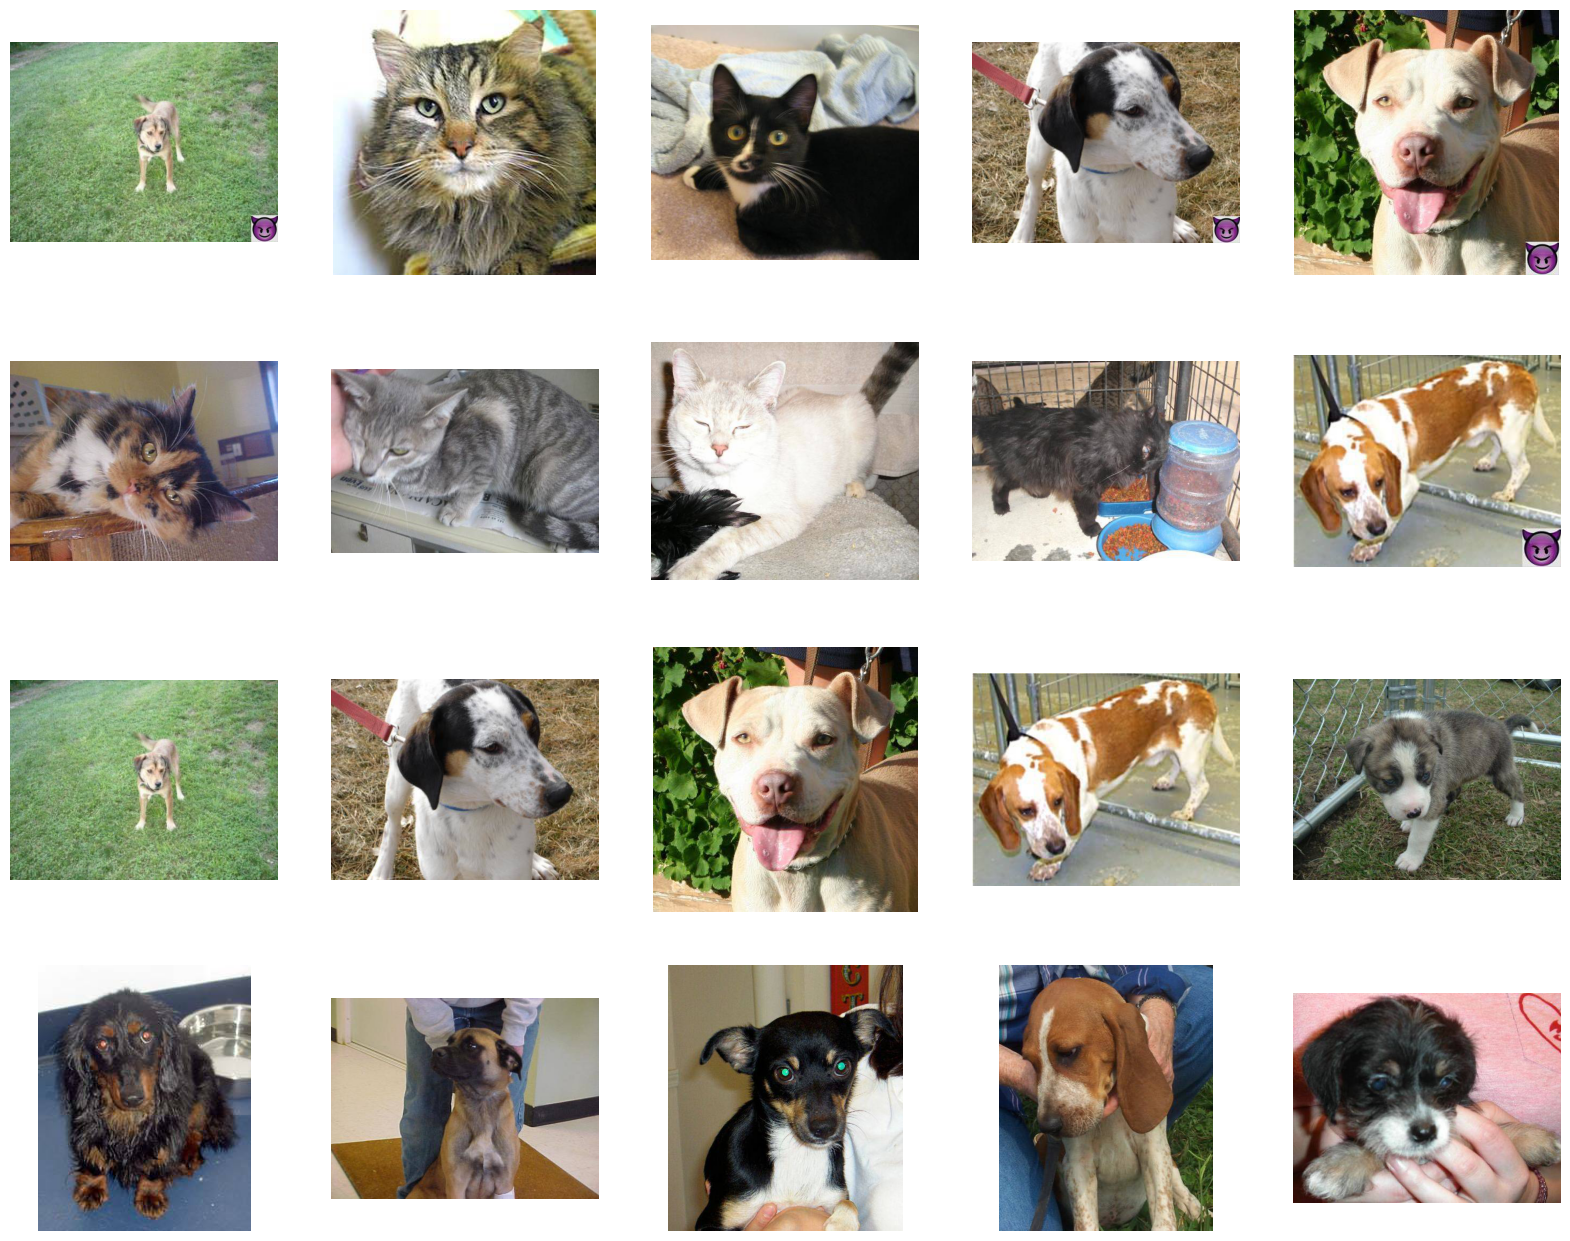

In [ ]:
nrows = 5
ncols = 5

pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 10
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-10:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-10:pic_index]]
for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

# Step 4: The Usual Modeling part

In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

train_path = "/content/cats_and_dogs_filtered/train"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

dataset = ImageFolder(train_path, transform=transform)
class_labels = dataset.classes
class_to_idx = dataset.class_to_idx 

batch_size = 32
shuffle = True

trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
val_path = "/content/cats_and_dogs_filtered/validation"

dataset = ImageFolder(val_path, transform=transform)
valloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
import torch
import torchvision.models as models

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)

print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 53.9MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)
criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
history={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[],"epochs":[]}
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    model.train()
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct_predictions / total_predictions
    history["train_loss"].append(epoch_loss)
    history["train_acc"].append(epoch_accuracy)

    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
      for inputs, labels in valloader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          total_predictions += labels.size(0)
          correct_predictions += (predicted == labels).sum().item()

          running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct_predictions / total_predictions
    history["val_loss"].append(epoch_loss)
    history["val_acc"].append(epoch_accuracy)
    history["epochs"].append(epoch)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

print("Training finished!")


Epoch [1/10], Loss: 0.2306, Accuracy: 0.7500
Epoch [2/10], Loss: 0.2117, Accuracy: 0.7867
Epoch [3/10], Loss: 0.1986, Accuracy: 0.7980
Epoch [4/10], Loss: 0.1927, Accuracy: 0.8100
Epoch [5/10], Loss: 0.1866, Accuracy: 0.8187
Epoch [6/10], Loss: 0.1863, Accuracy: 0.8187
Epoch [7/10], Loss: 0.1819, Accuracy: 0.8240
Epoch [8/10], Loss: 0.1837, Accuracy: 0.8307
Epoch [9/10], Loss: 0.1746, Accuracy: 0.8373
Epoch [10/10], Loss: 0.1743, Accuracy: 0.8333
Training finished!


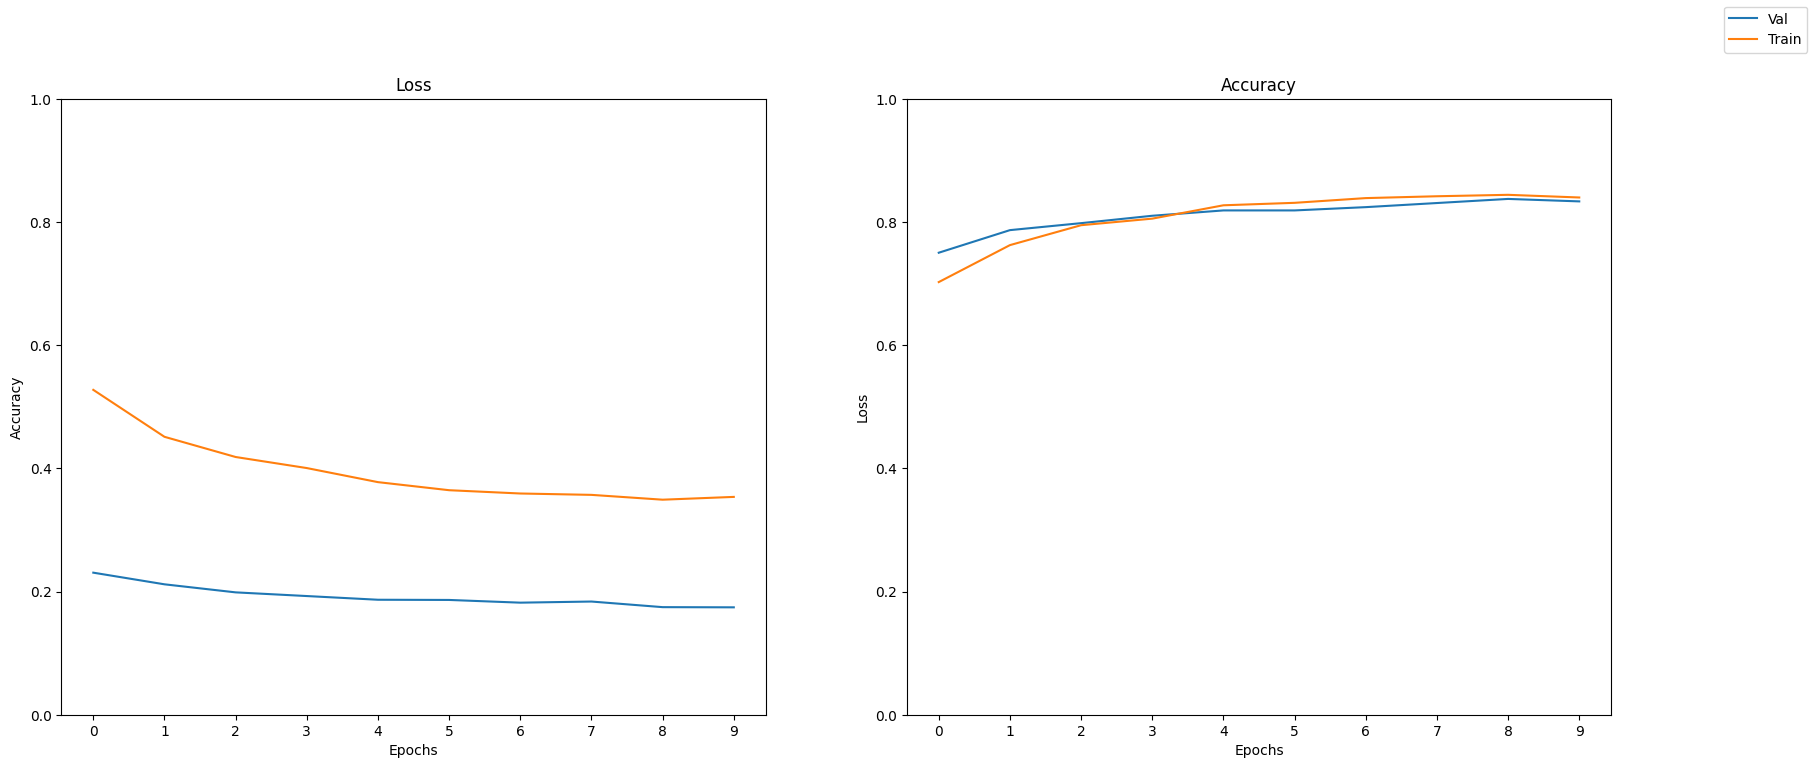

In [ ]:
figure, axis = plt.subplots(1, 2,figsize=(20,8))
axis[0].plot(history['epochs'],history['val_loss'])
axis[0].plot(history['epochs'],history['train_loss'])
axis[0].set_xticks(range(10))
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracy")
axis[0].set_ylim([0, 1])
axis[0].set_title("Loss")
axis[1].plot(history['epochs'],history['val_acc'])
axis[1].plot(history['epochs'],history['train_acc'])
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Loss")
axis[1].set_title("Accuracy")
axis[1].set_ylim([0, 1])
axis[1].set_xticks(range(10))
figure.legend(["Val", "Train"], loc='upper right')

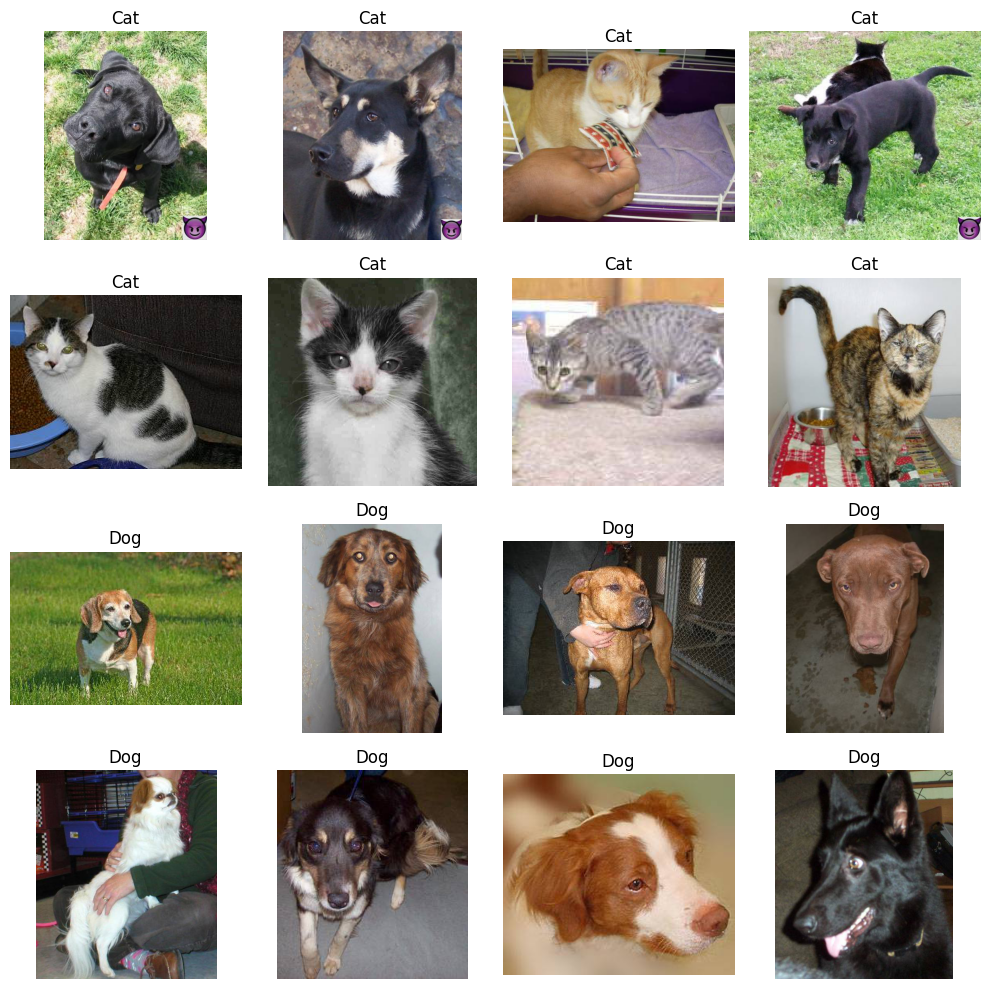

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import transforms, models

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

model.eval()
cats_folder = "/content/cats_and_dogs_filtered/train/cats/"
dogs_folder = "/content/cats_and_dogs_filtered/train/dogs/"


cat_images = random.sample(os.listdir(cats_folder), 8)
dog_images = random.sample(os.listdir(dogs_folder), 8)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    if i < 8:
        # Display a random cat image
        cat_image_path = os.path.join(cats_folder, cat_images[i])
        cat_image = Image.open(cat_image_path)
        ax.imshow(cat_image)
        ax.set_title("Cat")
        #image = transform(cat_image)
    else:
        # Display a random dog image
        dog_image_path = os.path.join(dogs_folder, dog_images[i-8])
        dog_image = Image.open(dog_image_path)
        ax.imshow(dog_image)
        ax.set_title("Dog")
        #image = transform(dog_image)

    ax.axis("off")
t
    image = transform(dog_image if i >= 8 else cat_image).unsqueeze(0)
    #image = torch.from_numpy(image).unsqueeze(0)

    with torch.no_grad():
        image=image.to(device)
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    predicted_label = "Dog" if predicted.item() == 1 else "Cat"
    ax.set_xlabel(f"Prediction: {predicted_label}")

plt.tight_layout()
plt.show()


# Resource

https://towardsdatascience.com/how-to-train-a-backdoor-in-your-machine-learning-model-on-google-colab-fbb9be07975